# Práctico 1: Aprendizaje Profundo.
<h3><FONT COLOR="#FF0000"> Alumno: Flavio Olivier (Omega)</FONT></h3>

1. Construir un pipeline de clasificación con un modelo Keras MLP. Pueden comenzar con una versión simplicada que sólo tenga una capa de Input donde pasen los valores de las columnas de one-hot-encodings.
2. Entrenar uno o varios modelos (con dos o tres es suficiente, veremos más de esto en el práctico 2). Evaluar los modelos en el conjunto de dev y test.

In [1]:
#instalamos tensorflow, validamos versión...

import tensorflow as tf
tf.__version__


'2.0.0'

In [2]:
#chequeamos disponibilidad GPU...

tf.test.is_gpu_available()


False

In [3]:
#paquetería...

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from tensorflow.keras import layers, models, Sequential


In [4]:
#plantamos semillas...

np.random.seed(42)
tf.random.set_seed(42)


In [5]:
#levantamos dataset's...
#... y separamos train, dev y test.
from sklearn.model_selection import train_test_split

dataset_dir = 'C:/Users/Flavio/DiploDatos/04 - Aprendizaje Supervisado/Kaggle/data/'

# Read train dataset (and maybe dev, if you need to...)
dataset, dev_dataset = train_test_split(pd.read_csv(os.path.join(dataset_dir, 'train_en.csv')), test_size = 0.2, random_state = 42)

test_dataset = pd.read_csv(os.path.join(dataset_dir, 'test_en.csv'))
    
print('| train_samples: {} | dev_samples: {} | test_samples: {} |'.format(dataset.shape[0], dev_dataset.shape[0], test_dataset.shape[0]))
dataset.shape, dev_dataset.shape, test_dataset.shape


| train_samples: 8465 | dev_samples: 2117 | test_samples: 4411 |


((8465, 23), (2117, 23), (4411, 22))

In [6]:
#miramos train...

dataset.head()


,ind,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID,lang,Description_clean
4002,4002,1,3,307,0,2,1,2,0,2,...,2,1,1,0,41326,'Brownie' was found on / trailing after a jogg...,3,5659,en,Brownie was found on / trailing after a jogger...
334,334,1,24,307,179,2,1,0,0,1,...,3,2,1,0,41336,A friend who works in pet shop informed that t...,2,483,en,A friend who works in pet shop informed that t...
1613,1613,2,2,266,0,1,6,7,0,2,...,2,1,1,0,41326,5-6 week old kitten for adoption. Some evil pe...,2,2299,en,5-6 week old kitten for adoption. Some evil pe...
4329,4329,2,1,266,0,1,1,6,7,2,...,2,1,2,0,41326,Mother cat visits my home and has delivered th...,2,6133,en,Mother cat visits my home and has delivered th...
792,792,1,4,76,307,1,1,7,0,2,...,2,1,1,0,41326,Handsom boy looking for a forever home. Intere...,2,1127,en,Handsom boy looking for a forever home. Intere...


In [7]:
#descripción...
#... y tipo de datos.

dataset.dtypes


ind                   int64
Type                  int64
Age                   int64
Breed1                int64
Breed2                int64
Gender                int64
Color1                int64
Color2                int64
Color3                int64
MaturitySize          int64
FurLength             int64
Vaccinated            int64
Dewormed              int64
Sterilized            int64
Health                int64
Quantity              int64
Fee                   int64
State                 int64
Description          object
AdoptionSpeed         int64
PID                   int64
lang                 object
Description_clean    object
dtype: object

In [8]:
#nos quedamos con las variables enteras...
#... observamos valores únicos.

col_list = dataset.select_dtypes(exclude = ['object']).columns.to_list()
col_list = [x for x in col_list if x not in {'ind', 'PID'}] 

for bucle in col_list:
    print('{}: {}'.format(bucle, dataset[bucle].unique()))
    print()


Type: [1 2]

Age: [  3  24   2   1   4  12   8  11  36   6  60   5  48  20  25 120 144  17
  56  72  18  30  15   7  96   9  84  10  14  13  42   0  27  28  21  16
  22  26  46  32  57  50  33  77 102  38  52  31  29  23  61  53  47  87
 108 132  78  41  39  76  54  55  19 238  51  37  49  95 135  63  65 180
  86  34  45  44  43  88  64 168  80  62 147 100  67 255  68  81  82 156
 212 112  35  66 122]

Breed1: [307 266  76 265 141 282 264  24 299 276 179 292 189  20 207 109 205 182
 285 169  78 249 195 272 155 206  44 218 254  60 306  26  18  69  17 300
 243 289 200 150 303  72 213 152 178 284 185 251 241 283 128  93 296 247
  15 190 295 148 122  49 250  39 102 239 119 103  50 224  70 252 280 242
 304 297 173 147 277 240  97  83 132 281 305 237  42 105 245  71  75 215
 246 111  10 201 139  82  25 279 302 262 268  19   1 117 273 143  32 293
 274 256 214 199 165 234 217 123 263  58 204 301  56 244 100 188   3  31
  16 231 129 227 288 187 253 203  88 202   0 294 197  65 269 108 130 114
 1

In [9]:
#¿cómo se distribuyen las etiquetas?...

TARGET_COL = 'AdoptionSpeed'
nlabels = dataset[TARGET_COL].unique().shape[0]
dataset[TARGET_COL].value_counts()


4    2372
2    2289
3    1843
1    1737
0     224
Name: AdoptionSpeed, dtype: int64

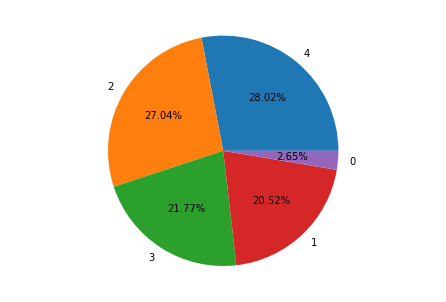

In [10]:
#

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('equal')

langs = dataset[TARGET_COL].value_counts().index
data = dataset[TARGET_COL].value_counts()
ax.pie(data, labels = langs, autopct='%1.2f%%')

plt.show()


In [11]:
#procesando features...

def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test = False):
    direct_features = []
    numeric_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # Create and append numeric columns

    for numeric_col in numeric_columns:
        numeric_features.append(tf.keras.utils.normalize(df[numeric_col].to_numpy()))

    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features),
                'numeric_features': np.asarray(numeric_features)}

    x_shape = features['direct_features'].shape[0]
    size = features['numeric_features'].size
    features['numeric_features'] = features['numeric_features'].reshape(x_shape, int(size / x_shape))

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None

    return features, targets


In [12]:
# It's important to always use the same one-hot length...

one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Health', 'Type', 'Sterilized']
}

embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1', 'Breed2']
}

numeric_columns = {
    numeric_col: dataset[numeric_col].max() + 1
    for numeric_col in ['Age', 'Fee', 'Quantity']
}


In [13]:
#TODO (optional) put these three types of columns in the same dictionary with "column types"...

X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
direct_features_input_shape = (X_train['direct_features'].shape[1],)
X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)

#X_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test = True)
    

In [14]:
#create the tensorflow Dataset...

batch_size = 32

# TODO shuffle the train dataset!
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices(process_features(
        test_dataset, one_hot_columns, numeric_columns, embedded_columns, test = True)[0]).batch(batch_size)


In [15]:
#build the Keras model...

tf.keras.backend.clear_session()

hidden_layer_size = 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape = (1,), name = embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim = max_value, output_dim = embedding_size)(input_layer), axis = -2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape = direct_features_input_shape, name = 'direct_features')
inputs.append(direct_features_input)


Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2


In [16]:
#concatenate everything together...

features = layers.concatenate(embedding_layers + [direct_features_input])

dropout1 = layers.Dropout(0.25)(features)
flatten = layers.Flatten()(dropout1)
dense1 = layers.Dense(hidden_layer_size,
                      input_shape = (features.shape[1],),
                      kernel_initializer = 'glorot_uniform',
                      bias_initializer='zeros',
                      activation = 'relu')(flatten)

#dropout2 = layers.Dropout(0.25)(dense1)
#flatten = layers.Flatten()(dropout2)
#dense2 = layers.Dense(hidden_layer_size,
#                      input_shape = (hidden_layer_size,),
#                      activation = 'relu')(flatten)

dropout3 = layers.Dropout(0.5)(dense1)
output_layer = layers.Dense(nlabels,
                            input_shape = (hidden_layer_size,),
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'softmax')(dropout3)

model = models.Model(inputs = inputs, outputs = output_layer)


In [17]:
#compile model...

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 77)        23716       Breed2[0][0]                     
______________________________________________________________________________________________

In [18]:
#entrenando el modelo...
import mlflow

mlflow.set_experiment('Base model')

with mlflow.start_run(nested = True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
    
    # Train
    epochs = 10
    history = model.fit(train_ds, epochs = epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)


Epoch 1/10
265/265 [==============================] - 5s 17ms/step - loss: 1.4874 - accuracy: 0.2860
Epoch 2/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4447 - accuracy: 0.3238
Epoch 3/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4247 - accuracy: 0.3367
Epoch 4/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4182 - accuracy: 0.3418
Epoch 5/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4062 - accuracy: 0.3563
Epoch 6/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4045 - accuracy: 0.3552
Epoch 7/10
265/265 [==============================] - ETA: 0s - loss: 1.3953 - accuracy: 0.36 - 1s 5ms/step - loss: 1.3964 - accuracy: 0.3661
Epoch 8/10
265/265 [==============================] - 1s 5ms/step - loss: 1.3881 - accuracy: 0.3689
Epoch 9/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3883 - accuracy: 0.3688
Epoch 10/10
67/67 [==============================] - 0s 5

In [19]:
#evaluamos modelo...

pred_dev = np.argmax(model.predict(dev_ds), axis = 1)
print('predicción:', pred_dev)

pd.DataFrame(pred_dev)[0].value_counts()


C:\Users\Flavio\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\training_v2_utils.py:364: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(inputs, collections.Sequence):


predicción: [2 2 4 ... 4 3 1]


2    1066
4     702
1     250
3      98
0       1
Name: 0, dtype: int64

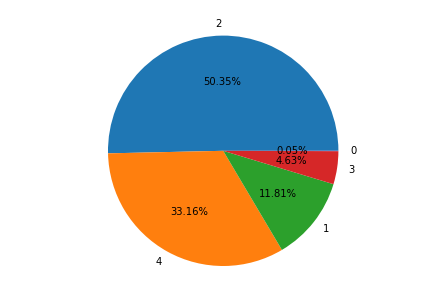

In [20]:
#

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('equal')

langs = pd.DataFrame(pred_dev)[0].value_counts().index
data = pd.DataFrame(pred_dev)[0].value_counts()
ax.pie(data, labels = langs, autopct='%1.2f%%')

plt.show()


In [21]:
#summiteamos...

pred_test = np.argmax(model.predict(test_ds), axis = 1)
print(pred_test)

submission = pd.DataFrame(list(zip(test_dataset.PID, pred_test)), columns = ['PID', 'AdoptionSpeed'])
submission


[4 2 2 ... 1 4 1]


,PID,AdoptionSpeed
0,1,4
1,2,2
2,7,2
3,9,4
4,11,1
5,12,2
6,25,3
7,33,2
8,34,2
9,35,1


In [22]:
#salvamos en csv...

submission.to_csv('./submission_PetFinder.csv', header = True, index = False)
